October 3 2021

In [1]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

Build random adjacency matrix

In [2]:
N = 300
p = 1/500

In [3]:
def get_A():
    A = (np.random.random((N, N)) < p).astype('float')
    for i in range(N):
        A[i,i] = 0

    for i in range(N):
        for j in range(N):
            A[i,j] = A[j,i]
    return A

Start with random state

In [4]:
def random_state():
    return 2*((np.random.random(N) > 0.5).astype('float') - 0.5)

In [5]:
def cost(E, A, x):
    return E + x.T @ A @ x

Test values that we get from random states

In [6]:
ctr = Counter()
A = get_A()
E = np.sum(A)
for _ in range(1000):
    c = cost(E, A, random_state())
    ctr[c] += 1
sorted(ctr.keys())[:5]

[92.0, 100.0, 108.0, 112.0, 116.0]

Try minimizing with simple local search

In [7]:
def local_search(A, f, x):
    E = np.sum(A)
    best = f(E, A, x)
    loops = 0
    print('-')
    print('start cost:', best)
    while True:
        if loops % 20 == 0:
            print('loop', loops, 'cost:', best)
        bestpos = None
        for i in range(N):
            x[i] *= -1
            newcost = f(E, A, x)
            if newcost < best:
                best = newcost
                bestpos = i
            x[i] *= -1
        if bestpos == None:
            break
        x[bestpos] *= -1
        loops += 1
    print('final cost:', best)
    return x

In [8]:
x = random_state()
x = local_search(A, cost, x)

-
start cost: 164.0
loop 0 cost: 164.0
loop 20 cost: 64.0
final cost: 12.0


New idea: try the functional

In [9]:
def g(b, f):
    return lambda *args: f(*args) * (b - f(*args)**2)

In [10]:
cost2 = g(N, cost)

In [11]:
for _ in range(2):
    x_old = np.copy(x)
    x2 = local_search(A, cost2, x)
    print(np.sum(x2 - x_old), 'diff from cost2')
    x = local_search(A, cost, x2)

-
start cost: 1872.0
loop 0 cost: 1872.0
loop 20 cost: -4691232.0
loop 40 cost: -15178592.0
final cost: -24809488.0
22.0 diff from cost2
-
start cost: 292.0
loop 0 cost: 292.0
loop 20 cost: 124.0
loop 40 cost: 44.0
final cost: 0.0
-
start cost: 0.0
loop 0 cost: 0.0
final cost: 0.0
0.0 diff from cost2
-
start cost: 0.0
loop 0 cost: 0.0
final cost: 0.0


The above works, but only if you end up at 0.

What about a simple 1-D function?

In [12]:
def func(x):
    return -30*np.cos(x)*np.minimum(9/x/x, 3) + 90

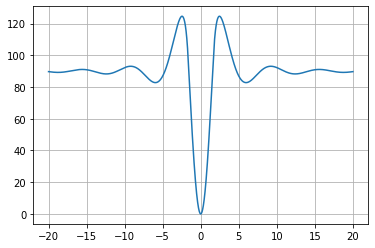

In [13]:
inps = np.linspace(-20, 20, 100000)
plt.plot(inps, func(inps))
plt.grid()

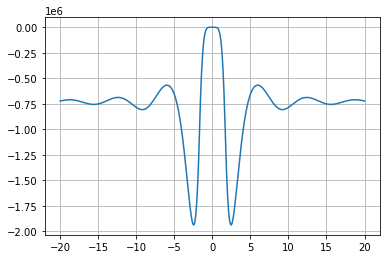

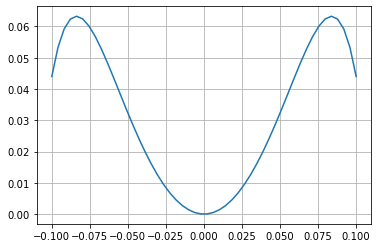

In [14]:
inps = np.linspace(-20, 20, 100000)
func2 = g(0.3, func)
plt.plot(inps, func2(inps))
plt.grid()

plt.figure()
inps = np.linspace(-0.1, +0.1)
plt.plot(inps, func2(inps))
plt.grid()

Now try minimizing:

In [15]:
from scipy.optimize import fmin_bfgs

In [16]:
output = fmin_bfgs(func, np.random.random()*100)
output

Optimization terminated successfully.
         Current function value: 89.860280
         Iterations: 5
         Function evaluations: 12
         Gradient evaluations: 6


array([43.93680628])

In [17]:
perturbation = 0.002

In [18]:
i = 0
while  i < 200:
    output = fmin_bfgs(func2, output[0] + (np.random.random()-0.5)*perturbation, disp=False)
    print('f2:', output[0])
    output = fmin_bfgs(func, output[0] + (np.random.random()-0.5)*perturbation, disp=False)
    print('f:', output[0])
    i += 1

f2: 40.791713368857685
f: 37.646039959742446
f2: 34.499612763860256
f: 43.93678638616231
f2: 47.08143253552639
f: 43.93681548161869
f2: 47.0814365274836
f: 43.93681438759613
f2: 47.08143437008191
f: 50.22568323596555
f2: 47.08144050768827
f: 47.081410821902644
f2: 47.08143543894255
f: 43.93686060069825
f2: 40.79171667620592
f: 37.64604460355624
f2: 34.4996126890453
f: 31.35221981497576
f2: 31.35222029916411
f: 31.352220943027163
f2: 28.203539150973803
f: 25.053079361077984
f2: 21.900077619729817
f: 12.406541444066196
f2: 15.580294407337428
f: 18.743252373453963
f2: 21.900078467482757
f: 25.0530795700924
f2: 21.900076720580216
f: 18.743252122005565
f2: 15.580294356421883
f: 18.743252979090745
f2: 9.210964519819845
f: 18.743252803422546
f2: 21.900077179121773
f: 18.743253556081196
f2: 21.900076821941006
f: 12.406543856320107
f2: 15.580294276885754
f: 12.406539741078568
f2: 15.580294361919822
f: 12.40653742120357
f2: 9.210964368916205
f: 12.406540720974439
f2: 15.580294140482058
f: 18.743

So the alternating minimizations can find the minima with energy $0$, amidst many local minima!